In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import data_util
from lenstronomy.Util import util as len_util
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
pickle_path = os.path.join(data_dir, 'sample_detectable_gglenses.pkl')
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

40 detectable lens(es)


In [3]:
snr_dict = dict()

In [4]:
masks = np.arange(0.1, 4.1, 0.5)

for mask_factor in tqdm(masks):
    snrs = []

    for gglens in detectable_gglenses:
        kwargs_model, kwargs_params = gglens.lenstronomy_kwargs(band='F106')

        magnitude_zero_point = Roman.F106_band_obs['magnitude_zero_point']
        lens_model = LensModel(kwargs_model['lens_model_list'])
        source_light_model = LightModel(kwargs_model['source_light_model_list'])
        lens_light_model = LightModel(kwargs_model['lens_light_model_list'])
        kwargs_lens = kwargs_params['kwargs_lens']
        kwargs_source = kwargs_params['kwargs_source']
        kwargs_lens_light = kwargs_params['kwargs_lens_light']
        kwargs_source_amp = data_util.magnitude2amplitude(source_light_model, kwargs_source, magnitude_zero_point)
        kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model, kwargs_lens_light, magnitude_zero_point)

        # set up image
        num_pix = 45  # at 0.11 pixels/", 10.01"
        psf_class = PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': 0.087})
        kwargs_numerics = {
                'supersampling_factor': 1,
                'supersampling_convolution': False
            }
        _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, Mcoord2pix = len_util.make_grid_with_coordtransform(
                numPix=num_pix,
                deltapix=0.11,
                subgrid_res=1,
                left_lower=False,
                inverse=False)
        kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                            'ra_at_xy_0': ra_at_xy_0,
                            'dec_at_xy_0': dec_at_xy_0,
                            'transform_pix2angle': Mpix2coord}
        pixel_grid = PixelGrid(**kwargs_pixel)
        image_model = ImageModel(data_class=pixel_grid,
                                    psf_class=psf_class,
                                    lens_model_class=lens_model,
                                    source_model_class=source_light_model,
                                    lens_light_model_class=lens_light_model,
                                    kwargs_numerics=kwargs_numerics)

        # get surface brightness arrays
        lens_surface_brightness = image_model.lens_surface_brightness(kwargs_lens_light_amp)
        source_surface_brightness = image_model.source_surface_brightness(kwargs_source_amp, kwargs_lens)
        total_image = image_model.image(kwargs_lens=kwargs_lens,
                                    kwargs_source=kwargs_source_amp,
                                    kwargs_lens_light=kwargs_lens_light_amp)
        
        # calculate region for source surface brightness array and count signal
        stdev = np.std(source_surface_brightness)
        mean = np.mean(source_surface_brightness)
        mask = source_surface_brightness < mean + (mask_factor * stdev)
        masked_source = np.ma.masked_array(source_surface_brightness, mask=mask)
        sum_source_counts = np.sum(masked_source)
        
        # estimate and add background
        min_zodiacal_light_f106 = 0.29
        thermal_background_f106 = 0
        estimated_background = (min_zodiacal_light_f106 * 1.5) + thermal_background_f106  # in counts/pixel
        estimated_background *= np.ones(total_image.shape)
        total_image += estimated_background

        # estimated total noise in 180s from https://roman.gsfc.nasa.gov/science/WFI_technical.html
        noise_180s = 5.5  # e- RMS
        noise_rms = noise_180s * (146 / 180)
        noise_array = np.random.poisson(noise_rms, total_image.shape)
        total_image += noise_array
        
        # count total signal
        masked_total = np.ma.masked_array(total_image, mask=mask)
        sum_total_counts = np.sum(masked_total)
        
        # calculate estimated SNR
        snr = sum_source_counts / np.sqrt(sum_total_counts)
        snrs.append(snr)

    snr_dict[mask_factor] = snrs

    # _, ax = plt.subplots(1, 6)

    # ax[0].imshow(lens_surface_brightness)
    # ax[1].imshow(source_surface_brightness)
    # ax[2].imshow(total_image)
    # ax[3].imshow(mask)
    # ax[4].imshow(masked_source)
    # ax[5].imshow(masked_total)

    # ax[1].set_title(f'SNR: {np.round(snr, 2)}')
    # ax[4].set_title(f'{np.round(sum_source_counts)} counts')
    # ax[5].set_title(f'{np.round(sum_total_counts)} counts')

    # for each in ax:
    #     each.set_axis_off()

    # plt.hist(source_surface_brightness)
    # # plt.imshow(mask)
    # # plt.colorbar()
    # plt.show()

100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


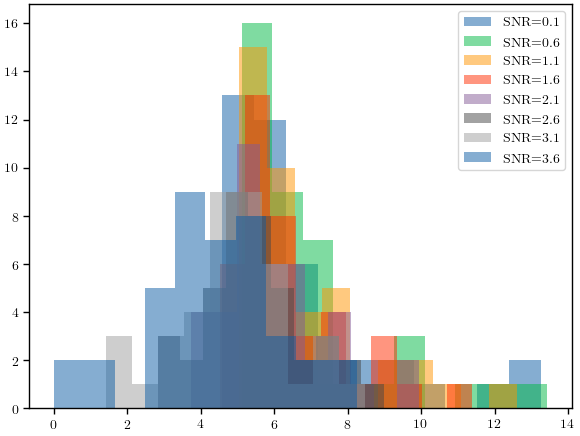

In [5]:
for i, mask in enumerate(masks):
    plt.hist(snr_dict[mask], label=f'SNR={mask}', alpha=0.5)

plt.legend()
plt.show()